<a href="https://colab.research.google.com/github/K-3-LT/Stock/blob/main/LSTMstockpriceprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter, DayLocator, MonthLocator

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout 


# 加载数据
#url = "https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv"
df = pd.read_csv('/content/603603.SS.csv')

# 数据预处理
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df)), columns=["Date", "Close"])
for i in range(0, len(data)):
    new_data["Date"][i] = data["Date"][i]
    new_data["Close"][i] = data["Close"][i]

new_data.index = new_data.Date
new_data.drop("Date", axis=1, inplace=True)

# 数据集划分
dataset = new_data.values
train = dataset[0:1000, :]
valid = dataset[1000:, :]
train_dates = new_data.index[:1000]
test_dates = new_data.index[1000:]


# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60, len(train)):
    x_train.append(scaled_data[i - 60:i, 0])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# 创建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(x_train, y_train, epochs=100, batch_size=32)

# 预测
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i - 60:i, 0])
X_test = np.array(X_test)

# 确保X_test是二维数组
if X_test.ndim == 1:
    X_test = X_test.reshape(-1, 1)

X_test = np.reshape(X_test, (X_test.shape[0], 60, 1))

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


Epoch 1/100
30/30 [==============================] - 16s 101ms/step - loss: 0.0142
Epoch 2/100
30/30 [==============================] - 4s 146ms/step - loss: 0.0031
Epoch 3/100
30/30 [==============================] - 3s 101ms/step - loss: 0.0021
Epoch 4/100
30/30 [==============================] - 3s 102ms/step - loss: 0.0022
Epoch 5/100
30/30 [==============================] - 3s 102ms/step - loss: 0.0019
Epoch 6/100
30/30 [==============================] - 4s 146ms/step - loss: 0.0019
Epoch 7/100
30/30 [==============================] - 3s 105ms/step - loss: 0.0018
Epoch 8/100
30/30 [==============================] - 3s 103ms/step - loss: 0.0016
Epoch 9/100
30/30 [==============================] - 3s 110ms/step - loss: 0.0015
Epoch 10/100
30/30 [==============================] - 4s 145ms/step - loss: 0.0016
Epoch 11/100
30/30 [==============================] - 3s 104ms/step - loss: 0.0016
Epoch 12/100
30/30 [==============================] - 3s 102ms/step - loss: 0.0017
Epoch 13/100

In [ ]:
def predict_future_prices(model, last_known_data, n_days):
    future_prices = []
    input_data = last_known_data.reshape(1, -1)
    input_data = input_data[:, -60:]
    
    for _ in range(n_days):
        input_data_reshaped = np.reshape(input_data, (1, 60, 1))
        predicted_price = model.predict(input_data_reshaped)
        future_prices.append(predicted_price[0][0])
        input_data = np.append(input_data, predicted_price)
        input_data = input_data[-60:]
        
    return scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))




n_future_days = 30  # 预测未来10天的价格
last_known_data = inputs[-200:]  # 使用最后60天的已知数据

future_dates = pd.date_range(pd.to_datetime(test_dates[-1]) + pd.Timedelta(days=1), periods=n_future_days, freq="D")

future_prices = predict_future_prices(model, last_known_data, n_future_days)

print(f"未来{len(future_prices)}天的预测股票价格：")
print(future_prices)


1/1 [==============================] - 0s 35ms/step
未来30天的预测股票价格：
[[6.126655 ]
 [6.119979 ]
 [6.1746016]
 [6.259292 ]
 [6.354589 ]
 [6.452064 ]
 [6.5485353]
 [6.6426716]
 [6.733799 ]
 [6.8216352]
 [6.9062366]
 [6.987919 ]
 [7.0671563]
 [7.1444755]
 [7.2203746]
 [7.295267 ]
 [7.36946  ]
 [7.443143 ]
 [7.5164104]
 [7.5892725]
 [7.661688 ]
 [7.733582 ]
 [7.8048706]
 [7.8754725]
 [7.945323 ]
 [8.014376 ]
 [8.082605 ]
 [8.150004 ]
 [8.216582 ]
 [8.282355 ]]


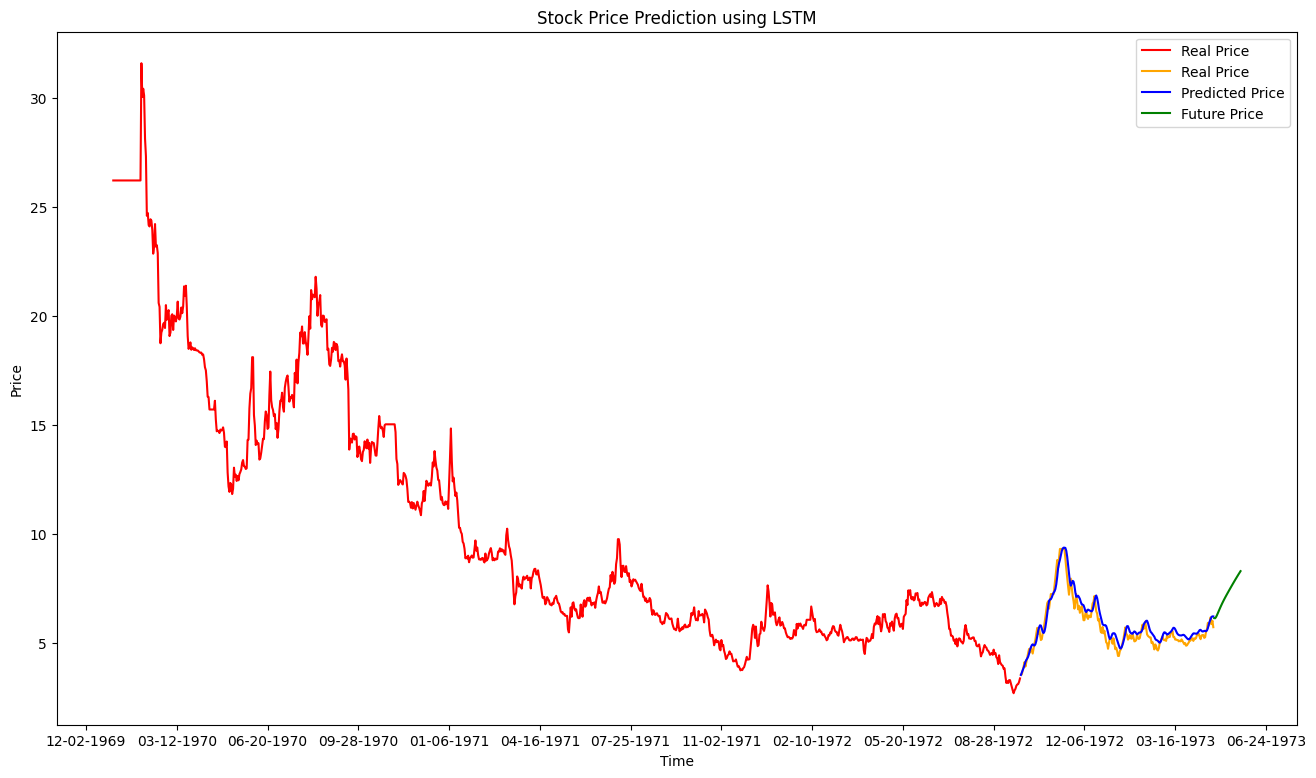

In [ ]:
plt.figure(figsize=(16,9))

# 设置横坐标轴的日期显示格式
date_fmt = DateFormatter("%m-%d-%Y")
plt.gca().xaxis.set_major_formatter(date_fmt)

# 设置横坐标轴的日期显示间隔
date_locator = DayLocator(interval=100) # 每隔7天显示一个日期
plt.gca().xaxis.set_major_locator(date_locator)

# 绘制真实价格
plt.plot(train_dates, train, color="red", label="Real Price")
plt.plot(test_dates, valid, color="orange", label="Real Price")
# 绘制真实价格
#plt.plot(valid, color="red", label="Real Price")
# 绘制测试集预测价格
plt.plot(test_dates, predicted_prices, color="blue", label="Predicted Price")
# 绘制测试集预测价格
#plt.plot(predicted_prices, color="blue", label="Predicted Price")

# 绘制未来预测价格
last_date = datetime.strptime(test_dates[-1], "%Y-%m-%d")
future_prices_dates = [last_date + timedelta(days=i) for i in range(1, len(future_prices) + 1)]
future_prices_dates = [date.strftime("%Y-%m-%d") for date in future_prices_dates]
plt.plot(future_prices_dates, future_prices, color="green", label="Future Price")

# 添加图例、标题和坐标轴标签
plt.legend()
plt.title("Stock Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()
